# AI Cell Me Competition
## I Summary
### Dataset

## II Analysis
### 2.1. Download dataset
If you're in Kaggle ![CellMe](https://www.kaggle.com/c/cell-me) competition and have installed kaggle api you can use below code to download dataset.

In [2]:
import os
import zipfile
wdir = os.getcwd()

if not os.path.isfile(wdir+"/data/train.csv.zip"):
    os.popen("~/.local/bin/kaggle competitions download -p ./data cell-me").read()
    
if not os.path.isfile(wdir+"/data/test.csv"):
    with zipfile.ZipFile(wdir +"/data/test.csv.zip","r") as zip_ref:
        zip_ref.extractall(wdir+"/data")
        
if not os.path.isfile(wdir+"/data/train.csv"):
    with zipfile.ZipFile(wdir +"/data/train.csv.zip","r") as zip_ref:
        zip_ref.extractall(wdir+"/data")

test_file_path = "data/test.csv"
train_file_path = "data/train.csv"

### 2.2. Loading libraries

In [19]:
import logging
import nltk
import re
import pandas as pd
import numpy as np
from collections import defaultdict
import random
from sklearn.datasets import make_classification
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, mean_squared_error
from sklearn.model_selection import train_test_split
import csv

#visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

### 2.3. Pieces of code

#### 2.3.0. Set seed

In [4]:
seed = 23
random.seed(seed)

#### 2.3.1. Load data

In [5]:
def loader(file_path,sample=False,nrows=1000):
    global wdir
    if not sample:
        return pd.read_csv(wdir+"/"+file_path,sep=",",header=0)
    return pd.read_csv(wdir+"/"+file_path,sep=",",header=0,nrows=nrows)

#### 2.3.1. Tokenizer 

In [6]:
class Tokenizer():
    @staticmethod
    def tokenize(text):
        pass

#### 2.3.2 Useful regexs

In [7]:
RE_EMOTICON = re.compile('(:\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\))')
RE_HTTP = re.compile("http(s)?://[/\.a-z0-9]+")

#### 2.3.3. Word tokenizer

In [8]:
class WordTokenizer(Tokenizer):
    def tokenize(text):
        words = str(text).lower().split()
        return words

#### 2.3.4. Stopwords

In [9]:
stopwords = ["a", "about", "after", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
            "before", "being", "between", "both", "by", "could", "did", "do", "does", "doing", "during", "each",
            "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
            "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've",
            "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "of",
            "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "own", "shan't", "she", "she'd",
            "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs",
            "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're",
            "they've", "this", "those", "through", "to", "until", "up", "very", "was", "wasn't", "we", "we'd",
            "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's",
            "which", "while", "who", "who's", "whom", "with", "would", "you", "you'd", "you'll", "you're", "you've",
            "your", "yours", "yourself", "yourselves", "above", "again", "against", "aren't", "below", "but", "can't",
            "cannot", "couldn't", "didn't", "doesn't", "don't", "down", "few", "hadn't", "hasn't", "haven't", "if",
            "isn't", "mustn't", "no", "nor",  "same", "too", "under", "why",
            "why's", "won't", "wouldn't",",",".",")","(","...","not", "off", "out", "over", "shouldn't","'s'",'phone','thi']

#### 2.3.5. Review tokenizer

In [10]:
class ReviewTokenizer(WordTokenizer):
    def tokenize(text,stopwords):
        ps = nltk.stem.PorterStemmer()
        tokens = super(ReviewTokenizer, ReviewTokenizer).tokenize(text)
        
        i = 0
        while i < len(tokens):
            token = tokens[i]
            matches = RE_EMOTICON.search(token)
            if matches:
                emoticon = matches.group(0)
                newTokens = token.split(emoticon)
                tokens[i] = emoticon
                tokens.extend(newTokens)
            else:
                del tokens[i]
                tokens[i:i] = nltk.word_tokenize(token)
            i = i + 1
            
        tokens = [ps.stem(token) for token in tokens]
        return [word for word in tokens if word not in stopwords]

#### 2.3.6 Words visualisation

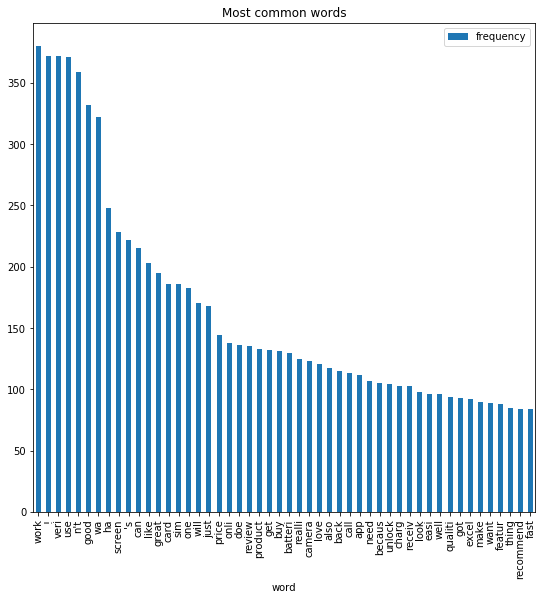

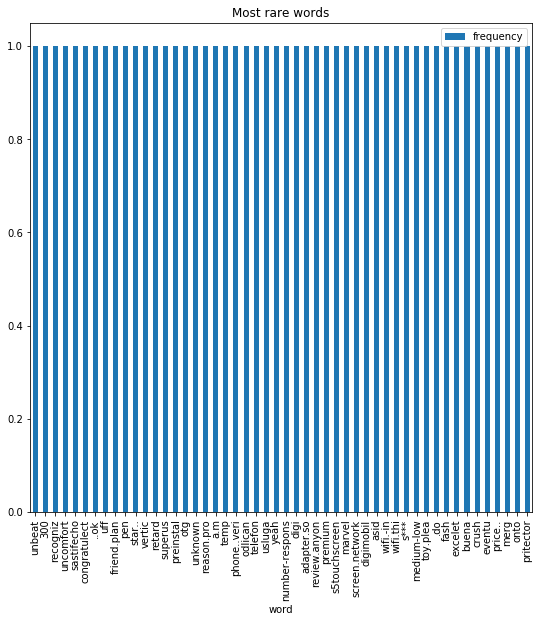

In [13]:
words = Counter()
data = loader(train_file_path,sample=True)
for i in data.index:
     tokens = ReviewTokenizer.tokenize(data['Reviews'].iat[i],stopwords)
     words.update(tokens)
    
mc = words.most_common(50)
df = pd.DataFrame(mc, columns=['word', 'frequency'])
df.plot(kind='bar', x='word',title="Most common words",figsize=(9,9))

lc = words.most_common()[-50:]
df = pd.DataFrame(lc, columns=['word', 'frequency'])
df.plot(kind='bar', x='word',title="Most rare words",figsize=(9,9))


#### 2.3.7 Build dictionary

In [14]:
def create_bow(documents, features,stopwords,text_column='Reviews', label_columns='Rating'):
    row = []
    col = []
    data = []
    labels = []
    
    for i in documents.index:
        tokens = ReviewTokenizer.tokenize(documents[text_column].iat[i],stopwords)
        if label_columns is not False:
            labels.append(documents[label_columns].iat[i])
        for token in set(tokens):
            if token not in features:
                continue
            row.append(i)
            col.append(features[token])
            data.append(1)
    return csr_matrix((data, (row, col)), shape=(len(documents), len(features))), labels

#### 2.3.8 Classification

In [18]:
min_word_count = 10
def experiment(min_word_count,sample=True,predict=False):
    global seed
    if not predict:
        data = loader(train_file_path,sample=sample)
        row_count = data.shape[0]
        split_point = int(row_count*1/5)
        test_data, train_data = data[:split_point], data[split_point:]
        test_data = test_data.reset_index(drop=True)
        train_data = train_data.reset_index(drop=True)
    else:
        train_data = loader(train_file_path, sample=sample)
        test_data = loader(test_file_path, sample=sample)
        

    words = Counter()
    for i in train_data.index:
         df = train_data['Reviews'].iat[i]
         tokens = ReviewTokenizer.tokenize(df,stopwords)
         words.update(tokens)


    common_words = list([k for k, v in words.most_common() if v > min_word_count])

    feature_dict = {}
    for word in common_words:
        feature_dict[word] = len(feature_dict)

    print("Training classifier...")
    
    X_train, y_train = create_bow(train_data, feature_dict,stopwords)
    list_of_labels = list(set(y_train))
    
    classifier = RandomForestClassifier(n_estimators=30, n_jobs=4, random_state=seed)
    classifier.fit(X_train, y_train)

    print("Testing...")
    if not predict:
        X_test, y_test = create_bow(test_data, feature_dict,stopwords)
    else:
        X_test, y_test = create_bow(test_data, feature_dict,stopwords,label_columns=False)
    predicted = classifier.predict(X_test)
    rmsa = False
    if not predict:
        print("=================== Results ===================")
        print("            Positive    Neutral     Negative   ")
        print("F1       ", f1_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
        print("Precision", precision_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
        print("Recall   ", recall_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
        errors = abs(predicted - y_test)
        print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
        rmsa = mean_squared_error(y_test, predicted)
        print("RMSA   ", rmsa)
    else:
        output = [];
        for i in test_data.index:
            _id = test_data['Id'].iat[i]
            pre = predicted[i]
            output.append((_id,pre))
        return output
    return rmsa,predicted

##### 2.3.9 Explore rare words threshold

Training classifier...
Testing...
=================== Results ===================
            Positive    Neutral     Negative   
F1        [0.40677966 0.18181818 0.17391304 0.23255814 0.7826087 ]
Precision [0.33333333 1.         0.33333333 0.3125     0.70714286]
Recall    [0.52173913 0.1        0.11764706 0.18518519 0.87610619]
Mean Absolute Error: 0.8 degrees.
RMSA    2.095
Training classifier...
Testing...
=================== Results ===================
            Positive    Neutral     Negative   
F1        [0.4        0.09090909 0.1        0.16216216 0.7734375 ]
Precision [0.30952381 0.5        0.33333333 0.3        0.69230769]
Recall    [0.56521739 0.05       0.05882353 0.11111111 0.87610619]
Mean Absolute Error: 0.86 degrees.
RMSA    2.345
Training classifier...
Testing...
=================== Results ===================
            Positive    Neutral     Negative   
F1        [0.43076923 0.08333333 0.0952381  0.25       0.776     ]
Precision [0.33333333 0.25       0.25       

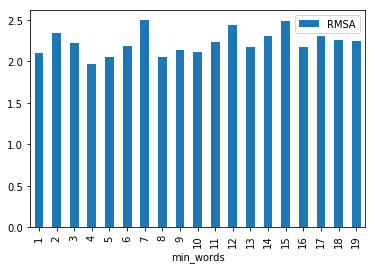

In [21]:
RMSA = []
for min_words in range(1,20):
    rmsa,_ = experiment(min_words, sample=True, predict=False)
    RMSA.append((min_words,rmsa))

df = pd.DataFrame(RMSA, columns=['min_words', 'RMSA'])
df.plot(kind='bar', x='min_words')

#### 2.3.10 Create submission file

In [22]:
predict = experiment(min_word_count=4,sample=False, predict=True)
with open('data/submission.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['Id','Rating'])
    for row in predict:
        csv_out.writerow(row)

Training classifier...
Testing...
